In [17]:
!pip install --default-timeout=100 xgboost


In [18]:
!pip install lightgbm


In [19]:
!pip install optuna


In [20]:
!pip install joblib

In [21]:
!pip install --default-timeout=100 h2o

In [22]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna
import joblib
import h2o
from h2o.automl import H2OAutoML


In [23]:
# Загрузка данных
def load_data(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Файл {file_path} не найден.")
    
    data = pd.read_csv(file_path)
    print("\n✅ Данные загружены успешно!")
    print(data.head(), "\n")
    print(data.info(), "\n")
    print(data.describe(), "\n")
    return data

Эта функция конвертирует дату, извлекает признаки и фильтрует пятничные продажи. Конвертирует Date в datetime, пробуя два возможных формата. > - Если даты остаются NaN, предупреждает пользователя. > - Извлекает дополнительные признаки из даты. > - Фильтрует пятничные продажи. > - Логарифмирует Weekly_Sales для стабилизации дисперсии.

In [24]:
def preprocess_data(data):
    try:
        data['Date'] = pd.to_datetime(data['Date'], format="%d-%m-%Y", errors='coerce')
    except Exception as e:
        print(f"❌ Ошибка преобразования даты: {e}")
        return None

    if data['Date'].isna().sum() > 0:
        print("⚠️ Внимание! В данных есть некорректные даты. Пробуем другой формат...")
        data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')

    if data['Date'].isna().sum() > 0:
        print("❌ Ошибка: после всех попыток преобразования данные остались некорректными!")
        return None

    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Week'] = data['Date'].dt.isocalendar().week
    data['Day'] = data['Date'].dt.day
    data['DayOfWeek'] = data['Date'].dt.dayofweek
    data['DayOfYear'] = data['Date'].dt.dayofyear

    friday_data = data[data['DayOfWeek'] == 4].copy()
    friday_data = friday_data[friday_data['Weekly_Sales'] > 0]
    friday_data['log_Weekly_Sales'] = np.log1p(friday_data['Weekly_Sales'])

    return friday_data


Выбирает признаки для модели. > - Разделяет данные на обучающие и тестовые (train_test_split). > - Создает ColumnTransformer для обработки числовых и категориальных данных.

In [25]:
def prepare_model_data(data):
    features = ['Store', 'Month', 'Week', 'Day', 'DayOfYear', 
                'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
    X = data[features]
    y = data['log_Weekly_Sales']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
    
    categorical_features = ['Store', 'Month', 'Holiday_Flag']
    numeric_features = [f for f in features if f not in categorical_features]

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
    
    return X_train, X_test, y_train, y_test, preprocessor


Использует Optuna для поиска лучших параметров.

In [26]:
def optimize_hyperparameters(X_train, y_train, preprocessor):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        }
        model = LGBMRegressor(**params, random_state=42)

        pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
        tscv = TimeSeriesSplit(n_splits=5)
        scores = cross_val_score(pipeline, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')

        return np.mean(scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    
    print(f"\n✅ Лучшие параметры LightGBM: {study.best_params}")
    return study.best_params


Запускает обучение и рассчитывает R2 и RMSE.

In [27]:
import matplotlib.pyplot as plt

def train_and_evaluate(X_train, X_test, y_train, y_test, preprocessor, best_params):
    model = LGBMRegressor(**best_params, random_state=42)

    pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_test_exp = np.expm1(y_test)
    y_pred_exp = np.expm1(y_pred)

    r2 = r2_score(y_test_exp, y_pred_exp)
    rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))

    print(f"\n✅ Результаты модели LightGBM: R2: {r2:.4f}, RMSE: {rmse:.4f}")

    # 📊 Визуализация фактических vs предсказанных значений
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_exp, y_pred_exp, alpha=0.5)
    plt.plot([y_test_exp.min(), y_test_exp.max()], [y_test_exp.min(), y_test_exp.max()], 'r--', label="Идеальное совпадение")
    plt.xlabel("Фактические значения")
    plt.ylabel("Предсказанные значения")
    plt.title("Фактические vs Предсказанные продажи")
    plt.legend()
    plt.show()

    # 📊 Гистограмма ошибок
    errors = y_test_exp - y_pred_exp
    plt.figure(figsize=(10, 5))
    sns.histplot(errors, bins=30, kde=True)
    plt.xlabel("Ошибка предсказания (реальное - предсказанное)")
    plt.ylabel("Частота")
    plt.title("Гистограмма ошибок предсказания")
    plt.show()

    # 📌 `print()` для анализа предсказаний
    print("\nПримеры фактических vs предсказанных продаж:")
    result_df = pd.DataFrame({'Фактические продажи': y_test_exp, 'Предсказанные продажи': y_pred_exp})
    print(result_df.head(10))  # Вывод первых 10 строк
    
    return pipeline


Он собирает все части кода и запускает процесс.

[I 2025-04-01 15:27:43,249] A new study created in memory with name: no-name-0739254b-bfc3-4f4a-833a-25e4b353c031



✅ Данные загружены успешно!
   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   

[I 2025-04-01 15:27:43,860] Trial 0 finished with value: -0.4185300605078194 and parameters: {'n_estimators': 857, 'max_depth': 3, 'learning_rate': 0.20966658216217818}. Best is trial 0 with value: -0.4185300605078194.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:27:44,062] Trial 1 finished with value: -0.40726884710515715 and parameters: {'n_estimators': 136, 'max_depth': 4, 'learning_rate': 0.2182744542029816}. Best is trial 1 with value: -0.40726884710515715.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:27:44,769] Trial 2 finished with value: -0.48596243545867346 and parameters: {'n_estimators': 320, 'max_depth': 8, 'learning_rate': 0.014731779724581524}. Best is trial 1 with value: -0.40726884710515715.



[LightGBM] [Info] Total Bins 1325
[LightGBM] [Info] Number of data points in the train set: 4290, number of used features: 51
[LightGBM] [Info] Start training from score 13.831163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 858, number of used features: 27
[LightGBM] [Info] Start training from score 13.847489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

[I 2025-04-01 15:27:45,429] Trial 3 finished with value: -0.41967135633692215 and parameters: {'n_estimators': 902, 'max_depth': 3, 'learning_rate': 0.12150086143418791}. Best is trial 1 with value: -0.40726884710515715.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1325
[LightGBM] [Info] Number of data points in the train set: 4290, number of used features: 51
[LightGBM] [Info] Start training from score 13.831163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-04-01 15:27:46,732] Trial 4 finished with value: -0.4895970584216725 and parameters: {'n_estimators': 646, 'max_depth': 10, 'learning_rate': 0.19250873502743251}. Best is trial 1 with value: -0.40726884710515715.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 858, number of used features: 27
[LightGBM] [Info] Start training from score 13.847489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-04-01 15:27:48,125] Trial 5 finished with value: -0.4688324917465965 and parameters: {'n_estimators': 775, 'max_depth': 7, 'learning_rate': 0.1686980509804766}. Best is trial 1 with value: -0.40726884710515715.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:27:49,086] Trial 6 finished with value: -0.4715021443292424 and parameters: {'n_estimators': 461, 'max_depth': 7, 'learning_rate': 0.022918805929008364}. Best is trial 1 with value: -0.40726884710515715.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:27:50,122] Trial 7 finished with value: -0.48078174255987066 and parameters: {'n_estimators': 478, 'max_depth': 9, 'learning_rate': 0.10264094050154979}. Best is trial 1 with value: -0.40726884710515715.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 858, number of used features: 27
[LightGBM] [Info] Start training from score 13.847489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-04-01 15:27:50,386] Trial 8 finished with value: -0.4252576083639476 and parameters: {'n_estimators': 203, 'max_depth': 4, 'learning_rate': 0.034706984310680374}. Best is trial 1 with value: -0.40726884710515715.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:27:51,033] Trial 9 finished with value: -0.4231631659577796 and parameters: {'n_estimators': 659, 'max_depth': 4, 'learning_rate': 0.12272164262214585}. Best is trial 1 with value: -0.40726884710515715.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:27:51,489] Trial 10 finished with value: -0.5322878396661819 and parameters: {'n_estimators': 165, 'max_depth': 12, 'learning_rate': 0.05696845911040981}. Best is trial 1 with value: -0.40726884710515715.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1325
[LightGBM] [Info] Number of data points in the train set: 4290, number of used features: 51
[LightGBM] [Info] Start training from score 13.831163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 858, number of used features: 27
[LightGBM] [Info] Start training from score 13.847489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

[I 2025-04-01 15:27:52,747] Trial 11 finished with value: -0.42953558024043736 and parameters: {'n_estimators': 981, 'max_depth': 5, 'learning_rate': 0.2948638536132489}. Best is trial 1 with value: -0.40726884710515715.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:27:53,215] Trial 12 finished with value: -0.42588736156572765 and parameters: {'n_estimators': 347, 'max_depth': 5, 'learning_rate': 0.06386380117257617}. Best is trial 1 with value: -0.40726884710515715.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1325
[LightGBM] [Info] Number of data points in the train set: 4290, number of used features: 51
[LightGBM] [Info] Start training from score 13.831163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-04-01 15:27:53,787] Trial 13 finished with value: -0.4141902980912751 and parameters: {'n_estimators': 813, 'max_depth': 3, 'learning_rate': 0.28792261627623156}. Best is trial 1 with value: -0.40726884710515715.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:27:54,805] Trial 14 finished with value: -0.44889676063270983 and parameters: {'n_estimators': 690, 'max_depth': 6, 'learning_rate': 0.29460748972433703}. Best is trial 1 with value: -0.40726884710515715.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 858, number of used features: 27
[LightGBM] [Info] Start training from score 13.847489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-04-01 15:27:55,206] Trial 15 finished with value: -0.4221730845271723 and parameters: {'n_estimators': 536, 'max_depth': 3, 'learning_rate': 0.08624199060433457}. Best is trial 1 with value: -0.40726884710515715.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1303
[LightGBM] [Info] Number of data points in the train set: 3432, number of used features: 45
[LightGBM] [Info] Start training from score 13.875809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-04-01 15:27:55,703] Trial 16 finished with value: -0.4307140897229174 and parameters: {'n_estimators': 343, 'max_depth': 5, 'learning_rate': 0.03686887668981779}. Best is trial 1 with value: -0.40726884710515715.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:27:55,893] Trial 17 finished with value: -0.4133617784492552 and parameters: {'n_estimators': 110, 'max_depth': 4, 'learning_rate': 0.18001254350298934}. Best is trial 1 with value: -0.40726884710515715.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:27:56,173] Trial 18 finished with value: -0.46240688781883393 and parameters: {'n_estimators': 120, 'max_depth': 6, 'learning_rate': 0.14438006492768765}. Best is trial 1 with value: -0.40726884710515715.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1303
[LightGBM] [Info] Number of data points in the train set: 3432, number of used features: 45
[LightGBM] [Info] Start training from score 13.875809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-04-01 15:27:56,753] Trial 19 finished with value: -0.5036022215095721 and parameters: {'n_estimators': 253, 'max_depth': 11, 'learning_rate': 0.08553934136518099}. Best is trial 1 with value: -0.40726884710515715.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 858, number of used features: 27
[LightGBM] [Info] Start training from score 13.847489
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-04-01 15:27:56,997] Trial 20 finished with value: -0.3964533605235352 and parameters: {'n_estimators': 112, 'max_depth': 6, 'learning_rate': 0.010331446333318119}. Best is trial 20 with value: -0.3964533605235352.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1303
[LightGBM] [Info] Number of data points in the train set: 3432, number of used features: 45
[LightGBM] [Info] Start training from score 13.875809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-04-01 15:27:57,256] Trial 21 finished with value: -0.39626930793199533 and parameters: {'n_estimators': 108, 'max_depth': 6, 'learning_rate': 0.010568016370355189}. Best is trial 21 with value: -0.39626930793199533.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261
[LightGBM] [Info] Number of data points in the train set: 2574, number of used features: 39
[LightGBM] [Info] Start training from score 13.815786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-04-01 15:27:57,772] Trial 22 finished with value: -0.46216656189043065 and parameters: {'n_estimators': 270, 'max_depth': 6, 'learning_rate': 0.010026128998403426}. Best is trial 21 with value: -0.39626930793199533.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:27:58,165] Trial 23 finished with value: -0.45375589493848667 and parameters: {'n_estimators': 167, 'max_depth': 8, 'learning_rate': 0.011362100955491181}. Best is trial 21 with value: -0.39626930793199533.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 858, number of used features: 27
[LightGBM] [Info] Start training from score 13.847489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-04-01 15:27:58,583] Trial 24 finished with value: -0.4694836692047265 and parameters: {'n_estimators': 239, 'max_depth': 6, 'learning_rate': 0.018504099776091687}. Best is trial 21 with value: -0.39626930793199533.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1303
[LightGBM] [Info] Number of data points in the train set: 3432, number of used features: 45
[LightGBM] [Info] Start training from score 13.875809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-04-01 15:27:59,394] Trial 25 finished with value: -0.47337433460648004 and parameters: {'n_estimators': 416, 'max_depth': 7, 'learning_rate': 0.02655247494022813}. Best is trial 21 with value: -0.39626930793199533.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:27:59,599] Trial 26 finished with value: -0.39971216417293887 and parameters: {'n_estimators': 111, 'max_depth': 5, 'learning_rate': 0.012656772723456645}. Best is trial 21 with value: -0.39626930793199533.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:27:59,816] Trial 27 finished with value: -0.401988461735537 and parameters: {'n_estimators': 104, 'max_depth': 5, 'learning_rate': 0.013869855578551886}. Best is trial 21 with value: -0.39626930793199533.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:28:00,510] Trial 28 finished with value: -0.48561527452843417 and parameters: {'n_estimators': 296, 'max_depth': 9, 'learning_rate': 0.014605560448179924}. Best is trial 21 with value: -0.39626930793199533.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1325
[LightGBM] [Info] Number of data points in the train set: 4290, number of used features: 51
[LightGBM] [Info] Start training from score 13.831163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 858, number of used features: 27
[LightGBM] [Info] Start training from score 13.847489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warni

[I 2025-04-01 15:28:00,998] Trial 29 finished with value: -0.4845670191848271 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.01976369410004431}. Best is trial 21 with value: -0.39626930793199533.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1303
[LightGBM] [Info] Number of data points in the train set: 3432, number of used features: 45
[LightGBM] [Info] Start training from score 13.875809
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1325
[LightGBM] [Info] Number of data points in the train set: 4290, number of used features: 51
[LightGBM] [Info] Start training from score 13.831163
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 858, number of used features: 27
[LightGBM] [Info] Start train

[I 2025-04-01 15:28:01,656] Trial 30 finished with value: -0.46746978257198035 and parameters: {'n_estimators': 399, 'max_depth': 6, 'learning_rate': 0.012683630927820764}. Best is trial 21 with value: -0.39626930793199533.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:28:01,857] Trial 31 finished with value: -0.4104292212904923 and parameters: {'n_estimators': 106, 'max_depth': 5, 'learning_rate': 0.015570564193424594}. Best is trial 21 with value: -0.39626930793199533.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1325
[LightGBM] [Info] Number of data points in the train set: 4290, number of used features: 51
[LightGBM] [Info] Start training from score 13.831163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-04-01 15:28:02,222] Trial 32 finished with value: -0.43147624255721767 and parameters: {'n_estimators': 213, 'max_depth': 5, 'learning_rate': 0.011470210636957755}. Best is trial 21 with value: -0.39626930793199533.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 858, number of used features: 27
[LightGBM] [Info] Start training from score 13.847489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-04-01 15:28:02,565] Trial 33 finished with value: -0.4635330247958039 and parameters: {'n_estimators': 157, 'max_depth': 7, 'learning_rate': 0.016545168799174895}. Best is trial 21 with value: -0.39626930793199533.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:28:02,774] Trial 34 finished with value: -0.37527458689491927 and parameters: {'n_estimators': 102, 'max_depth': 4, 'learning_rate': 0.01007651816414695}. Best is trial 34 with value: -0.37527458689491927.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1261
[LightGBM] [Info] Number of data points in the train set: 2574, number of used features: 39
[LightGBM] [Info] Start training from score 13.815786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-04-01 15:28:03,004] Trial 35 finished with value: -0.40816523111428127 and parameters: {'n_estimators': 170, 'max_depth': 4, 'learning_rate': 0.0102266140224854}. Best is trial 34 with value: -0.37527458689491927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:28:03,298] Trial 36 finished with value: -0.4188053377669411 and parameters: {'n_estimators': 301, 'max_depth': 3, 'learning_rate': 0.027767917606778807}. Best is trial 34 with value: -0.37527458689491927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:28:03,745] Trial 37 finished with value: -0.464910847999432 and parameters: {'n_estimators': 236, 'max_depth': 6, 'learning_rate': 0.020162717225396518}. Best is trial 34 with value: -0.37527458689491927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:28:04,123] Trial 38 finished with value: -0.45518268765774533 and parameters: {'n_estimators': 158, 'max_depth': 7, 'learning_rate': 0.013091097418026786}. Best is trial 34 with value: -0.37527458689491927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:28:04,378] Trial 39 finished with value: -0.4275393033962901 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.039014073482905844}. Best is trial 34 with value: -0.37527458689491927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:28:05,658] Trial 40 finished with value: -0.48777026331146073 and parameters: {'n_estimators': 596, 'max_depth': 9, 'learning_rate': 0.016413578177289778}. Best is trial 34 with value: -0.37527458689491927.
[I 2025-04-01 15:28:05,850] Trial 41 finished with value: -0.399179259803666 and parameters: {'n_estimators': 108, 'max_depth': 5, 'learning_rate': 0.012850378903909556}. Best is trial 34 with value: -0.37527458689491927.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 858, number of used features: 27
[LightGBM] [Info] Start training from score 13.847489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-04-01 15:28:06,050] Trial 42 finished with value: -0.3924456356572605 and parameters: {'n_estimators': 102, 'max_depth': 5, 'learning_rate': 0.0121700374015192}. Best is trial 34 with value: -0.37527458689491927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:28:06,288] Trial 43 finished with value: -0.397378650902365 and parameters: {'n_estimators': 144, 'max_depth': 4, 'learning_rate': 0.010126895845774099}. Best is trial 34 with value: -0.37527458689491927.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 858, number of used features: 27
[LightGBM] [Info] Start training from score 13.847489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-04-01 15:28:06,501] Trial 44 finished with value: -0.40629424511016915 and parameters: {'n_estimators': 163, 'max_depth': 4, 'learning_rate': 0.010031891173029732}. Best is trial 34 with value: -0.37527458689491927.
[I 2025-04-01 15:28:06,706] Trial 45 finished with value: -0.4132257802476801 and parameters: {'n_estimators': 203, 'max_depth': 3, 'learning_rate': 0.023332128939762786}. Best is trial 34 with value: -0.37527458689491927.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 858, number of used features: 27
[LightGBM] [Info] Start training from score 13.847489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-04-01 15:28:07,030] Trial 46 finished with value: -0.4244642882977825 and parameters: {'n_estimators': 266, 'max_depth': 4, 'learning_rate': 0.011109582180139674}. Best is trial 34 with value: -0.37527458689491927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:28:07,232] Trial 47 finished with value: -0.4226103080442579 and parameters: {'n_estimators': 143, 'max_depth': 4, 'learning_rate': 0.017463110138591996}. Best is trial 34 with value: -0.37527458689491927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

[I 2025-04-01 15:28:08,406] Trial 48 finished with value: -0.46622110539670425 and parameters: {'n_estimators': 727, 'max_depth': 6, 'learning_rate': 0.014713299371958203}. Best is trial 34 with value: -0.37527458689491927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-01 15:28:09,128] Trial 49 finished with value: -0.47022664971931183 and parameters: {'n_estimators': 373, 'max_depth': 7, 'learning_rate': 0.04555789972400023}. Best is trial 34 with value: -0.37527458689491927.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

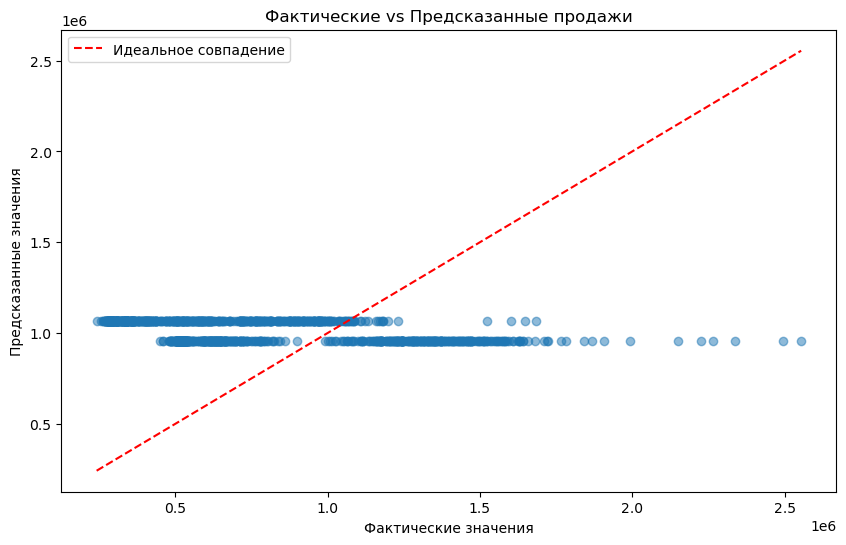

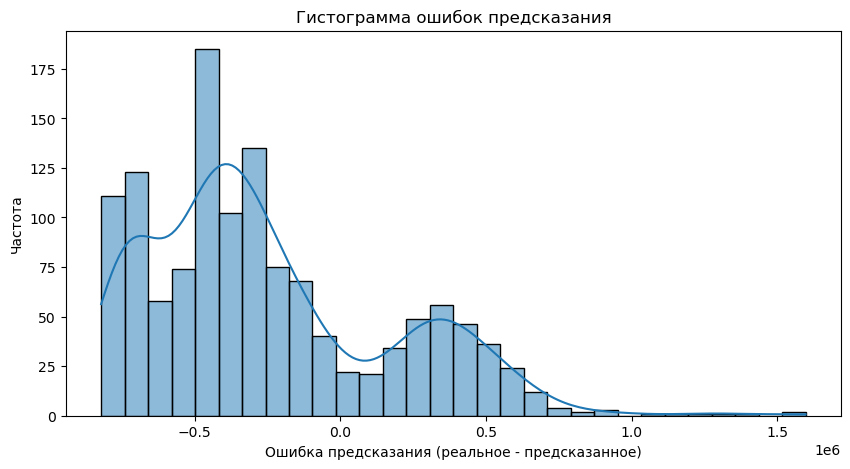


Примеры фактических vs предсказанных продаж:
      Фактические продажи  Предсказанные продажи
5148            536006.73          956650.101368
5149            529852.70          956650.101368
5150            510382.50          956650.101368
5151            513615.82          956650.101368
5152            519255.68          956650.101368
5153            513015.35          956650.101368
5154            460020.74          956650.101368
5155            515777.97          956650.101368
5156            540189.70          956650.101368
5157            513327.55          956650.101368

✅ Модель LightGBM успешно сохранена!


In [28]:
def main():
    data = load_data('Walmart.csv')
    friday_data = preprocess_data(data)

    if friday_data is None or friday_data.empty:
        return
    
    X_train, X_test, y_train, y_test, preprocessor = prepare_model_data(friday_data)
    best_lgbm_params = optimize_hyperparameters(X_train, y_train, preprocessor)
    lgbm_pipeline = train_and_evaluate(X_train, X_test, y_train, y_test, preprocessor, best_lgbm_params)

    joblib.dump(lgbm_pipeline, 'best_lgbm_model.pkl')
    print("\n✅ Модель LightGBM успешно сохранена!")

if __name__ == "__main__":
    main()


Проблема с диапазоном предсказаний 

Большая часть предсказанных значений сконцентрирована около 1 миллиона, независимо от фактических значений. Это может означать, что модель:

Недостаточно вариативна (плохо улавливает различия в продажах).

Использует слишком простые признаки, не позволяя предсказаниям варьироваться.

Ошибка модели Если фактические продажи далеко от красной линии, значит, модель делает систематическую ошибку. Например:

Если точка далеко ниже линии, значит, модель переоценила продажи.

Если выше линии, значит, модель недооценила продажи.



Анализ кода и результатов
Структура кода

Код включает: загрузку данных (load_data()), предобработку (preprocess_data()), подготовку для модели (prepare_model_data()), оптимизацию гиперпараметров (optimize_hyperparameters()), обучение (train_and_evaluate()) и сохранение модели (joblib.dump()).

Используются пайплайны (Pipeline) для обработки данных и обучения.

Оценка модели

R² показывает уровень объяснения вариации в данных. Высокие значения R² (>0.8) говорят о хорошей предсказательной способности.

RMSE измеряет среднюю ошибку предсказаний. Низкие значения RMSE указывают на точность модели.

Оптимизация гиперпараметров (Optuna) улучшает метрики.

Анализ визуализации

Гистограмма ошибок предсказания показывает, что распределение ошибок имеет длинный хвост в сторону положительных значений. Это может говорить о наличии крупных выбросов или неполной модели.

Рассеянный график фактических vs предсказанных значений показывает расхождения между реальными и прогнозируемыми данными. Наличие большой дисперсии указывает на возможную недостачу информации в входных данных.

